# Custom Variable Scaling

While default variable scaling is often sufficient for many applications, users may wish to customize this for their optimization problems. This entails explicitly specifying the scaling behavior of a variable during optimization. Recall that scaling is applied to variables during optimization in order to bring the variables into approximately common range in order to improve convergence and optimizer performance.

In [31]:
import numpy as np

from optiland import optic, optimization
from optiland.optimization.scaling import LinearScaler, ReciprocalScaler

Define a starting lens:

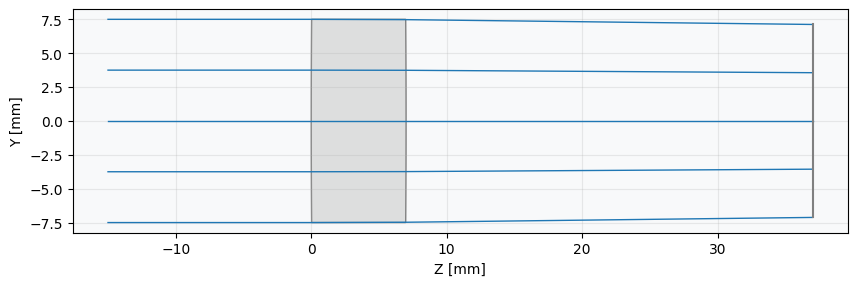

In [32]:
lens = optic.Optic()

# add surfaces
lens.add_surface(index=0, thickness=np.inf)
lens.add_surface(index=1, thickness=7, radius=1000, material="N-SF11", is_stop=True)
lens.add_surface(index=2, thickness=30, radius=-1000, surface_type='even_asphere')  # Second lens surface is an even asphere
lens.add_surface(index=3)

# set aperture
lens.set_aperture(aperture_type="EPD", value=15)

# add field
lens.set_field_type(field_type="angle")
lens.add_field(y=0)

# add wavelength
lens.add_wavelength(value=0.55, is_primary=True)

# draw lens
_ = lens.draw(num_rays=5)

Define optimization problem:

In [33]:
problem = optimization.OptimizationProblem()

Add operands (targets for optimization):

In [34]:
"""
Define RMS spot size properties for the optimization:
    1. Surface number = -1, implying last surface (image surface)
    2. Normalized field coordinates (Hx, Hy) = (0, 0)
    3. Number of rays = 5, corresponds to number of rings in hexapolar distribution
        (see distribution documentation)
    4. Wavelength = 0.55 µm
    5. Pupil distribution = hexapolar
"""

input_data = {
    "optic": lens,
    "surface_number": -1,
    "Hx": 0,
    "Hy": 0,
    "num_rays": 5,
    "wavelength": 0.55,
    "distribution": "hexapolar",
}

# add RMS spot size operand
problem.add_operand(
    operand_type="rms_spot_size",
    target=0,
    weight=1,
    input_data=input_data,
)

### Define Variables with Custom Scaling

Here, we will define three variables for the optimizer. Instead of using the default scaling for all of them, we will specify custom scaling strategies for each variable. Note that the default scaling for each variable type will suffice for most problems, but customization may be helpful for certain problems.

1.  **Surface 1 - Reciprocal Radius**: We use the `radius` variable type with the `ReciprocalScaler` scaler. This is often superior to a standard radius for optimization because it handles the transition from a convex to a concave surface (passing through infinity, or a flat surface) smoothly. For the optimizer, the variable value simply passes through zero, which is much more stable. Note that the `reciprocal_radius` variable itself also implements this strategy, but we build it manually to demonstrate the functionality.

2.  **Surface 2 - Custom Linear Scaled Radius**: For the second surface, we'll still vary the radius, but we'll override the default `LinearScaler` with our own parameters. This demonstrates how you can tune the scaling to a specific range you expect the variable to occupy.

3.  **Surface 2 - Aspheric Coefficient**: Aspheric surfaces provide more degrees of freedom to correct aberrations. However, their coefficients are often tiny (e.g., `1e-3`). We will vary the 2nd-order coefficient (`A_2`), which uses the `PowerScaler` by default to bring its value into a range the optimizer can handle effectively.

In [35]:
# 1. Add the radius of surface 1 as a reciprocal variable
reciprocal_scaler = ReciprocalScaler() # Use the ReciprocalScaler for this variable
problem.add_variable(lens, "radius", surface_number=1, scaler=reciprocal_scaler, min_val=500.0)

# 2. Add the radius of surface 2, overriding the default linear scaling
linear_scaler = LinearScaler(factor=1/200.0, offset=0) # Scale relative to 200mm
problem.add_variable(optic=lens, variable_type="radius", surface_number=2, scaler=linear_scaler)

# 3. Add the aspheric coefficient on surface 2.
# This will use its own default, a PowerScaler.
problem.add_variable(
    optic=lens,
    variable_type="asphere_coeff",
    surface_number=2,
    coeff_number=0,
)

Check initial merit function value and system properties:

In [36]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │                30.0924 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ rms spot size  │        0 │              │              │        1 │   5.486 │   5.486 │            100 │
╘════╧════════════════╧══════════╧══════════════╧══════════════╧══════════╧═════════╧═════════╧════════════════╛
╒════╤═════════════════╤═══════════╤═════════╤══════════════╤══════════════╕
│    │ Variable Type   │   Surface │   Value │   Min. Bound │ Max. Bound   │
╞════╪═══════════════

Define optimizer:

In [37]:
optimizer = optimization.OptimizerGeneric(problem)

Run optimization:

In [38]:
optimizer.optimize(tol=1e-9)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.0018808834377063122
        x: [ 3.568e-02 -5.000e+00 -5.927e-06]
      nit: 5
      jac: [ 2.088e-08  1.281e-05 -4.337e-06]
     nfev: 76
     njev: 19
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Print merit function value and system properties after optimization:

In [39]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │             0.00188088 │           99.9937 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ rms spot size  │        0 │              │              │        1 │   0.043 │   0.043 │            100 │
╘════╧════════════════╧══════════╧══════════════╧══════════════╧══════════╧═════════╧═════════╧════════════════╛
╒════╤═════════════════╤═══════════╤════════════════╤══════════════╤══════════════╕
│    │ Variable Type   │   Surface │          Value │   Min. Bound │ Max. Bound   │
╞════╪═

Draw final lens:

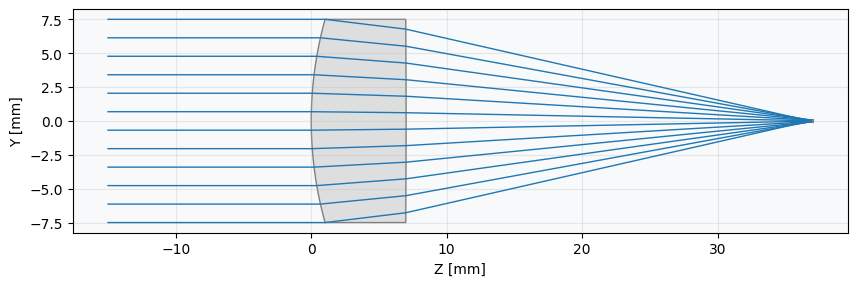

In [40]:
_ = lens.draw(num_rays=12)